In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interpn
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

from math import sqrt, atan, log, exp, sin, cos, tan
from thermal_loads_221206 import *

In [2]:
# environment settings: 
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',50)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

np.core.arrayprint.set_printoptions(linewidth= 180)
np.set_printoptions(threshold=np.inf)

# Project name

In [3]:
project = "house"

# Weather data

In [4]:
we = pd.DataFrame.from_dict(we_dict)
we.head()

,CP,Localité,theta_e_base,theta_e_min,theta_e_avg
0,9300,Aalst,-7,0,10
1,9880,Aalter,-7,0,10
2,3200,Aarschot,-7,0,10
3,2630,Aartselaar,-7,0,10
4,1790,Affligem,-7,0,10


In [5]:
we.loc[we['CP'] == 4950]

,CP,Localité,theta_e_base,theta_e_min,theta_e_avg
551,4950,Waimes,-11,-3,7


In [6]:
we[we['Localité'].str.contains("Wai")]

,CP,Localité,theta_e_base,theta_e_min,theta_e_avg
551,4950,Waimes,-11,-3,7


# General data

In [7]:
t_ext = -11
t_min = -3
t_avg = 7

t_in  = 20  # Base internal temperature 

DU    = 0.05      #[W/m2/K]
U_wd  = 1.50 + DU #[W/m2/K]
U_dr  = 1.67 + DU #[W/m2/K]
n_50  = 0.6

# Reheating additional power (0: maximum oversize factor, 1: EN12831 Annex F Table F1, 2 : dynamic simulation )
rh_type = 2

# Ventilation data

In [8]:
##### Zone, internal temperature t_in_star, 
# number of floors, total floor area, internal volume, 
# fan supply air flow (m³/h), fan extracted air flow (m³/h), efficiency of heat recovery,
# ATD outdoor air flow (m³/h), 
# Air flow from indoor adjoining spaces (m³/h), temperature of the indoor adjoining space

vent = \
[('office',   20, 1, 46.48,  142, 250, 250, 0.86, 0, 0, 20),
 ('dwelling', 20, 2, 31.35,  192, 250, 250, 0.86, 0, 0, 20)]

# System operation

In [9]:
##### Zone, minimum temperature set point, reheating time (h), 
# Maximum heating oversize factor for heating up after setback  (>= 1), fraction of fan supplied air flow during set back time

setback = \
[('office',   15, 1, 3, 0  ),
 ('dwelling', 15, 1, 3, 0.5)]  # radiators

hourly = \
[('office',   (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0) ),
 ('dwelling', (0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0) )]

daily = \
[('office',   (1, 1, 1, 1, 1, 0, 0) ),
 ('dwelling', (1, 1, 1, 1, 1, 1, 1) )]

weekly = \
[('office',   (1, 1, 1, 0, 0, 1, 1, 1, 1) ),
 ('dwelling', (1, 1, 1, 1, 1, 1, 1, 1, 1) )]

# Wall dimensions and environments

In [10]:
# Zone, azimuth, slope, wall_type, dimension 1, dimension 2, h_in (W/m2-K), h_ext (W/m2-K), t_out (°C)
# Fraction of the zone heating power provided by a radiative heat source included in the wall

walls = \
[('office',     0,   0, 'floor_ext',  9.3,           6.6,  8,  8, t_ext, 0),
 ('office',   180,  90, 'wall_ext',   6.6,   3.06 + 0.46,  8,  8, t_ext, 0),
 ('office',   -90,  90, 'wall_ext',   9.3,   3.06 + 0.46,  8,  8, t_ext, 0),
 ('office',     0,  90, 'wall_ext',   6.6,   3.06 + 0.46,  8,  8, t_ext, 0),
 ('office',    90,  90, 'wall_ext',   9.3,   3.06 + 0.46,  8,  8, t_ext, 0),
 ('office',     0, 180, 'roof',       6.6,           2.7,  8,  8, t_ext, 0),
 ('office',     0, 180, 'ceil_sep',   5.6,           5.6,  8,  8, t_avg, 0),
 
 ('dwelling',   0,   0, 'floor_sep',  5.6,           5.6,  8,  8, t_avg, 0),
 ('dwelling',   0, 180, 'ceil_int',   5.6,           5.6,  8,  8, t_in , 0),
 ('dwelling',   0, 180, 'floor_int',  5.6,           5.6,  8,  8, t_in , 0),
 ('dwelling', 180,  90, 'wall_ext',   6.6, 2*3.06 + 0.63,  8,  8, t_ext, 0),
 ('dwelling', -90,  90, 'wall_ext',   6.6, 2*3.06 + 0.63,  8,  8, t_ext, 0),
 ('dwelling',   0,  90, 'wall_ext',   6.6, 2*3.06 + 0.63,  8,  8, t_ext, 0),
 ('dwelling',  90,  90, 'wall_ext',   6.6, 2*3.06 + 0.63,  8,  8, t_ext, 0),
 ('dwelling',   0, 180, 'roof',       6.6,           6.6,  8, 23, t_ext, 0)]

In [11]:
# Zone, azimuth, slope, wall_type, number of identical windows, breadth, height
windows = \
[('office',   -90, 90, 'wall_ext', 1, 0.90, 2.59),
 ('office',   -90, 90, 'wall_ext', 2, 0.90, 2.59),
 
 ('dwelling', -90, 90, 'wall_ext', 1, 1.46, 1.78),
 ('dwelling',  90, 90, 'wall_ext', 1, 0.56, 0.84),
 ('dwelling',   0, 90, 'wall_ext', 5, 1.20, 2.59),
 ('dwelling',   0, 90, 'wall_ext', 1, 0.61, 2.59),
 ('dwelling', -90, 90, 'wall_ext', 3, 0.90, 2.59),
 ('dwelling', -90, 90, 'wall_ext', 1, 0.90, 2.59),
 ('dwelling', -90, 90, 'wall_ext', 3, 0.90, 2.59)]

In [12]:
# Zone, azimuth, slope, wall_type, number of identical external doors, breadth, height
doors = \
[('office',   180, 90, 'wall_ext', 1, 1.00, 2.17),
 ('dwelling', 180, 90, 'wall_ext', 1, 1.00, 2.17)]

# Materials data

In [13]:
materials = pd.DataFrame(columns=["material","lambda","rho","c"])

materials = materials.append({"material":'Plaster_Panel'      ,"lambda":0.32, "rho":1200,"c":1000}, ignore_index=True)
materials = materials.append({"material":'Dry_screed_Panel'   ,"lambda":0.38, "rho":1225,"c":1000}, ignore_index=True)
materials = materials.append({"material":'DF_panel'           ,"lambda":0.20, "rho":1200,"c":1000}, ignore_index=True)
materials = materials.append({"material":'Glass_wool'         ,"lambda":0.035,"rho":20,  "c":840},  ignore_index=True)
materials = materials.append({"material":'OSB'                ,"lambda":0.12, "rho":553, "c":1700}, ignore_index=True)
materials = materials.append({"material":'Wood_cement_Panel'  ,"lambda":0.35, "rho":1250,"c":1000}, ignore_index=True)
materials = materials.append({"material":'Wood'               ,"lambda":0.13, "rho":600, "c":1600}, ignore_index=True)
materials = materials.append({"material":'PIR'                ,"lambda":0.025,"rho":40,  "c":840},  ignore_index=True)
materials = materials.append({"material":'EPS_board'          ,"lambda":0.034,"rho":25,  "c":1300}, ignore_index=True)
materials = materials.append({"material":'Expanded_foam'      ,"lambda":0.036,"rho":12,  "c":1300}, ignore_index=True)
materials = materials.append({"material":'Waterproof_membrane',"lambda":0.230,"rho":1300,"c":1000}, ignore_index=True)
materials = materials.append({"material":'Gravels'            ,"lambda":2.0,  "rho":2000,"c":1000}, ignore_index=True)
materials = materials.append({"material":'Air_layer_160mm'    ,"lambda":0.711,"rho":1.2, "c":1000}, ignore_index=True)

materials = composite_material(materials, 'Insulation_layer', 'Glass_wool', 'Wood', 0.6, 0.06)

# Wall types data

In [14]:
# 'floor_ext', 'floor_int', 'roof', 'roof_terrace', 'wall_ext'
# From indoor to outdoor

walls_types = \
[('floor_ext', 0, 0.015, 'Wood'),
 ('floor_ext', 1, 0.028, 'Dry_screed_Panel'),
 ('floor_ext', 2, 0.018, 'OSB'),
 ('floor_ext', 3, 0.300, 'Insulation_layer'),
 ('floor_ext', 4, 0.015, 'Wood_cement_Panel'),
 ('floor_ext', 5, 0.100, 'PIR'),
 
 ('floor_int', 0, 0.015, 'Wood'),
 ('floor_int', 1, 0.028, 'Dry_screed_Panel'),
 ('floor_int', 2, 0.018, 'OSB'),
 ('floor_int', 3, 0.160, 'Air_layer_160mm'),
 ('floor_int', 4, 0.140, 'Insulation_layer'),
 ('floor_int', 5, 0.015, 'Wood_cement_Panel'),
 ('floor_int', 6, 0.080, 'Insulation_layer'),
 ('floor_int', 7, 0.060, 'Gravels'),
 ('floor_int', 8, 0.030, 'DF_panel'),

 ('roof', 0, 0.030, 'DF_panel'),
 ('roof', 1, 0.060, 'Gravels'),
 ('roof', 2, 0.080, 'Insulation_layer'),
 ('roof', 3, 0.015, 'OSB'),
 ('roof', 4, 0.300, 'Insulation_layer'),
 ('roof', 5, 0.018, 'OSB'),
 ('roof', 6, 0.120, 'PIR'),
 ('roof', 7, 0.005, 'Waterproof_membrane'),
 
 ('wall_ext', 0, 0.015, 'Plaster_Panel'),
 ('wall_ext', 1, 0.090, 'Insulation_layer'),
 ('wall_ext', 2, 0.018, 'OSB'),
 ('wall_ext', 3, 0.300, 'Insulation_layer'),
 ('wall_ext', 4, 0.016, 'Wood_cement_Panel') 
]

walls_types = add_copy        ('floor_int', 'floor_sep', walls_types)
walls_types = add_inverse_copy('floor_int', 'ceil_int' , walls_types)
walls_types = add_inverse_copy('floor_sep', 'ceil_sep' , walls_types)

In [15]:
# list of wall types in contact with the ground
GRwalls = []

# list of wall types with thermal bridges
DUwalls = ['floor_ext', 'roof', 'wall_ext']

# list of wall types separating building entities
BEwalls = ['floor_sep', 'ceil_sep']

# List of internal walls totally included in the zone (both faces in contact with the same zone) > define two walls
INTwalls = ['floor_int', 'ceil_int']

# Heating power

In [16]:
gen = [t_ext, t_min, t_avg, t_in, DU, U_wd, U_dr, n_50, rh_type]

dfRC, dfh, dfd, dfw, \
dfwc, dfwp, dfar, dfat, dfhl, dfzg, dfresz, dfresa, zname_list, trh_h, hr, Qhmx, Qhvr, Tivr, fover  = \
            thermal_loads(gen, vent, setback, hourly, daily, weekly, \
                        walls, windows, doors, materials, walls_types,  \
            GRwalls, DUwalls, BEwalls, INTwalls)

with pd.ExcelWriter(project + ".xlsx") as writer: 
    
    # Wall layers
    dfwc.to_excel(writer, sheet_name='wall_layers') 

    # Wall u_values
    dfwp.to_excel(writer, sheet_name='wall_parameters') 

    # Wall areas by facade
    dfar.to_excel(writer, sheet_name='wall_areas_by_orientation') 

    # Wall total areas 
    dfat.to_excel(writer, sheet_name='wall_areas') 

    # Zone Heat loss Coefficients
    dfhl.to_excel(writer, sheet_name='Heat_loss_coefficients') 

    # Heating powers by zone
    dfresz.to_excel(writer, sheet_name='powers_by_zone') 

    # Results by facade
    dfresa.to_excel(writer, sheet_name='powers_by_zone_and_facade') 

# Reheating dynamic simulation results

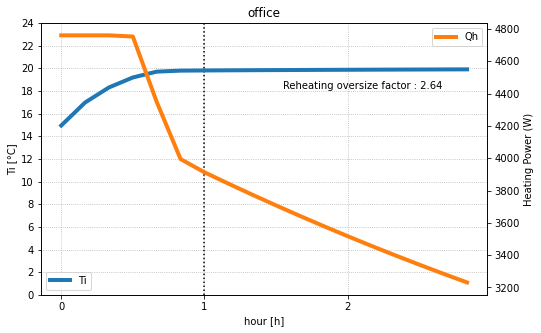

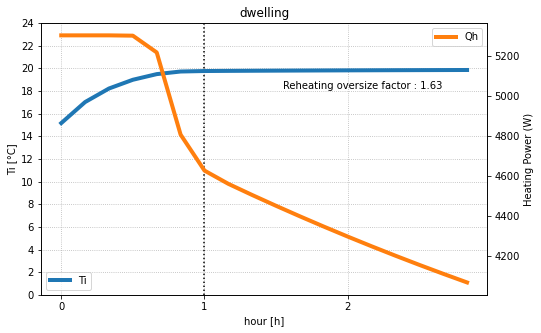

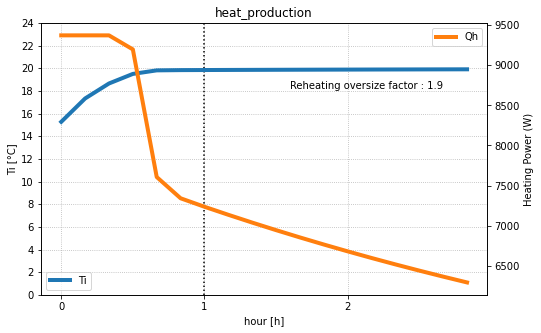

In [17]:
if rh_type == 2:
    
    for i in range(0, len(Qhmx)):
        
        fig, ax1 = plt.subplots(figsize = (8, 5));

        ax1.plot(hr,Tivr[i,:],'tab:orange', color = 'C0', linewidth=4, label="Ti")

        ax1.grid(linestyle = 'dotted')
        ax1.set_xlabel('hour [h]')
        ax1.set_ylabel('Ti [°C]')
        ax1.set_ylim([0,24])
        ax1.set_yticks(np.arange(0, 24 + 1, 2))

        plt.title(zname_list[i])
        plt.xticks(np.arange(0, hr[-1] + 1, 1))
        plt.vlines(trh_h[i], 0, Qhmx[i], colors='k', linestyles='dotted')

        ax2 = ax1.twinx()
        ax2.plot(hr,Qhvr[i,:],'tab:blue', color = 'C1', linewidth=4, label="Qh")
        ax2.set_ylabel('Heating Power (W)')

        ax1.legend(loc='lower left')
        ax2.legend(loc='upper right')
        ax2.text(0.9, 0.75, 'Reheating oversize factor : ' + str(round(fover[i], 2)), \
             horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes);

    

# Heat loss coefficients

,H_T_wl,H_T_wd,H_T_dr,H_V_su,H_V_ATD,H_V_ia,H_V_ie
zone,,,,,,,
office,28.75,10.84,3.73,11.87,0.0,0.0,2.89
dwelling,29.19,56.58,3.73,11.87,0.0,0.0,3.91
heat_production,57.94,67.42,7.46,23.74,0.0,0.0,6.80


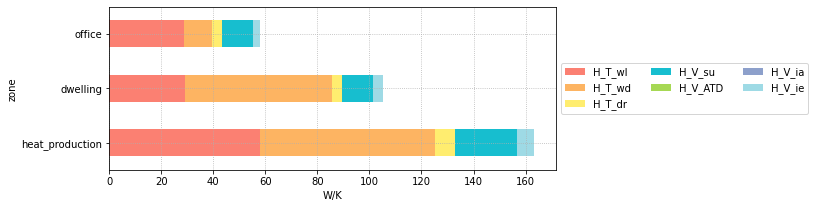

In [18]:
c1 = (0.984313725490196, 0.5019607843137255, 0.4470588235294118)   # orange
c2 = (0.9921568627450981, 0.7058823529411765, 0.3843137254901961)  # orange pastel
c3 = (1.0, 0.9294117647058824, 0.43529411764705883) # yellow
c4 = (0.09019607843137255, 0.7450980392156863, 0.8117647058823529) # blue
c5 = (0.6509803921568628, 0.8470588235294118, 0.32941176470588235) # green-yellow
c6 = (0.5529411764705883, 0.6274509803921569, 0.796078431372549)   # mean blue
c7 = (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)  # lightblue

dfzg.iloc[::-1].plot.barh(figsize=(8,3),stacked=True, color = (c1,c2,c3,c4,c5,c6,c7))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3);
plt.xlabel("W/K")
plt.grid(linestyle = 'dotted');

dfzg[['H_T_wl', 'H_T_wd', 'H_T_dr', 'H_V_su', 'H_V_ATD', 'H_V_ia', 'H_V_ie']].round(2)

# Thermal loads by zone

,Transmission [W],Ventilation [W],Reheating [W],Total [W]
zone,,,,
office,1342,457,2960,4760
dwelling,2774,489,2040,5304
heat_production,3983,946,4443,9373


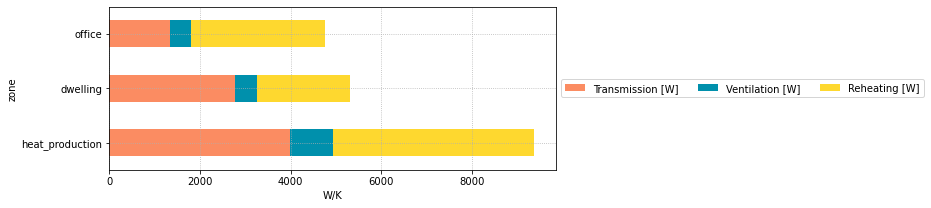

In [19]:
c0 = (102/256, 194/256, 165/256)  # green
c1 = (252/256, 141/256, 98/256)   # orange
c2 = (141/256, 160/256, 203/256)  # blue
c3 = (231/256, 138/256, 195/256)  # pink
c4 = (166/256, 216/256, 84/256)   # light green
c5 = (255/256, 217/256, 47/256)   # yellow
c6 = (229/256, 196/256, 148/256)  # beige
c7 = (179/256, 179/256, 179/256)  # grey
c8 = (250/256, 170/256, 174/256)  # old pink
c9 = (  0/256, 145/256, 173/256)  # dark blue
c10 = (248/256, 234/256, 173/256) # ivory


dfresz[['Transmission [W]','Ventilation [W]','Reheating [W]']].iloc[::-1].plot.barh(figsize=(8,3),stacked=True,color=(c1,c9,c5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3);
plt.xlabel("W")
plt.grid(linestyle = 'dotted');

dfresz

# Thermal loads by zone and by facade

In [20]:
dfresa

,azimuth,Transmission [W],Ventilation [W],Reheating [W],Total [W]
zone,,,,,
office,-90,575,133,865,1575
office,0,194,94,614,903
office,90,273,133,865,1273
office,180,299,94,614,1008
dwelling,-90,1090,122,510,1722
dwelling,0,1012,122,510,1645
dwelling,90,293,122,510,925
dwelling,180,378,122,510,1010
heat_production,-90,1623,252,1183,3059


# Energy consumptions

In [21]:
%%time

zname_list, day, Qhiz_kWh, Qhcz_kWh, fr_overcooliz, fr_overcoolcz, DQh, Qhiv, Tiiv, t_ext_sbs \
            = simulation(dfRC, dfh, dfd, dfw)

Wall time: 30.5 s


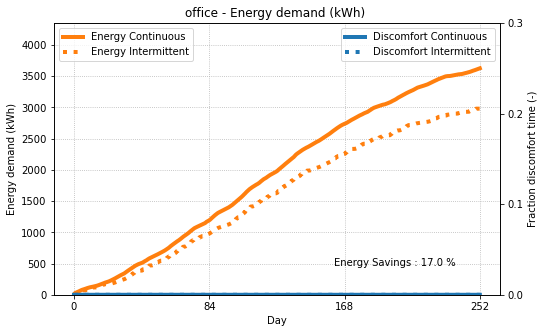

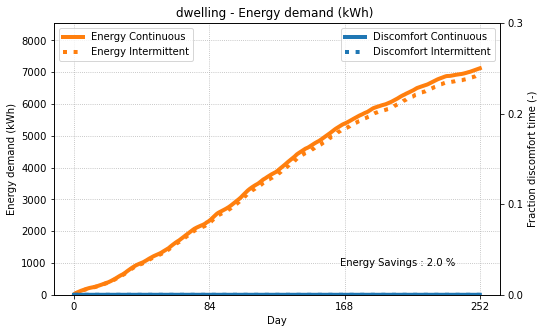

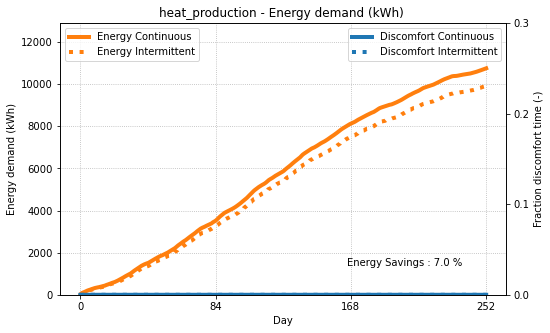

In [22]:
for i in range(0, len(dfRC)):
    
    fig, ax1 = plt.subplots(figsize = (8,5));
    
    Emax = max(Qhcz_kWh[i,-1], Qhiz_kWh[i,-1])
    ax1.plot(day, Qhcz_kWh[i,:],'tab:orange', color = 'C1', linewidth=4, label="Energy Continuous")
    ax1.plot(day, Qhiz_kWh[i,:],'tab:orange', color = 'C1', linestyle = 'dotted', linewidth=4, label="Energy Intermittent")
    ax1.grid(linestyle = 'dotted')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Energy demand (kWh)')
    ax1.set_ylim([0, 1.2 * Emax])

    plt.title(zname_list[i] + ' - Energy demand (kWh) ')
    plt.xticks(np.arange(0, day[-1] + 1, 14 * 6))

    ax2 = ax1.twinx()
    Fmax = max(fr_overcoolcz[i,-1], fr_overcooliz[i,-1])
    Fmaxgraph = (int(Fmax * 10) + 3) / 10
    ax2.plot(day, fr_overcoolcz[i,:],'tab:blue', color = 'C0', linewidth=4, label="Discomfort Continuous")
    ax2.plot(day, fr_overcooliz[i,:],'tab:blue', color = 'C0', linestyle = 'dotted', linewidth=4, label="Discomfort Intermittent")
    ax2.set_ylabel('Fraction discomfort time (-)')
    ax2.set_ylim([0,Fmaxgraph])
    ax2.set_yticks(np.arange(0, Fmaxgraph + 0.1, 0.1))

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.text(0.9, 0.1, 'Energy Savings : ' + str(DQh[i]) + ' %', \
         horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes);

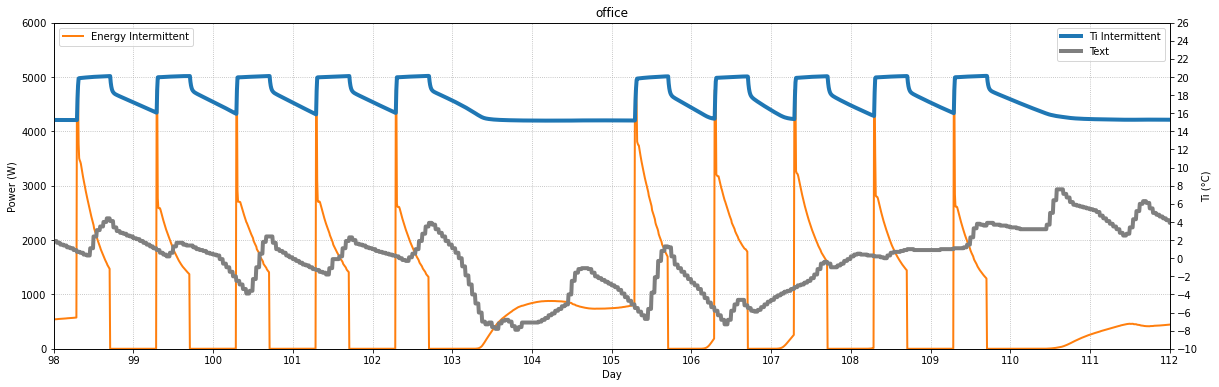

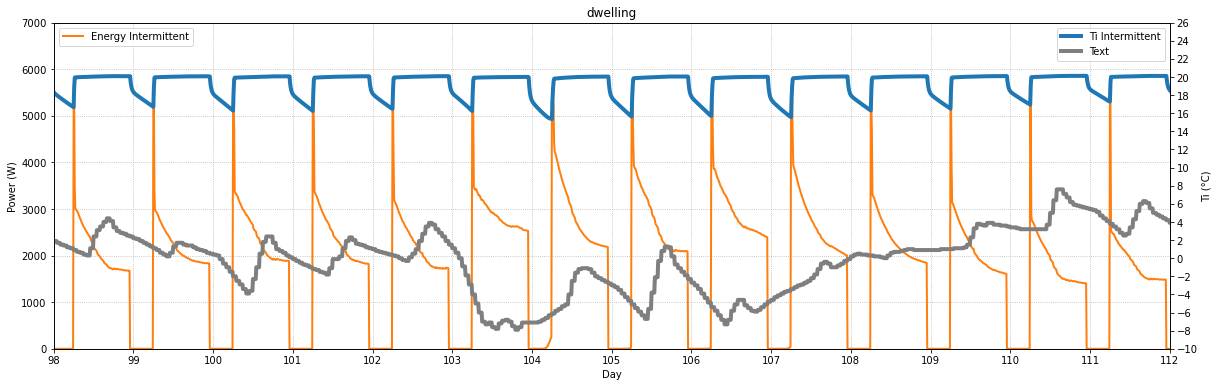

In [23]:
for i in range(0, len(dfRC)-1):
    
    fig, ax1 = plt.subplots(figsize = (20,6));
    
    Emax = np.max(Qhiv[i,:])
    Qmaxgraph = (int(Emax / 1000) + 2) * 1000
    ax1.plot(day, Qhiv[i,:],'tab:orange', color = 'C1', linewidth=2, label="Energy Intermittent")
    ax1.grid(linestyle = 'dotted')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Power (W)')
    ax1.set_ylim([0, Qmaxgraph])

    plt.title(zname_list[i])
    plt.xticks(np.arange(0, day[-1] + 1, 1))

    plt.xlim(98,112)

    ax2 = ax1.twinx()
    ax2.plot(day, Tiiv[i,:],'tab:blue', color = 'C0', linewidth=4, label="Ti Intermittent")
    ax2.plot(day, t_ext_sbs,'tab:blue', color = 'C7', linewidth=4, label="Text")
    ax2.set_ylabel('Ti (°C)')
    ax2.set_ylim([0, 22])
    ax2.set_yticks(np.arange(-10, 28, 2))

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right');